
# CNNs and LSTMs for Multilablel classififcation



In [ ]:
import numpy as np
import pandas as pd
import re

# keras
from keras.models import Model, Sequential
from keras.initializers import glorot_uniform
# layers
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional, Permute, multiply
from keras.layers import BatchNormalization,RepeatVector,Concatenate, Dot, Conv1D, GlobalMaxPool1D
from keras.layers import SpatialDropout1D, Lambda, GlobalAveragePooling1D
from keras.layers.embeddings import Embedding
#optimizers
from keras.optimizers import Adam
#loss
from keras.losses import BinaryCrossentropy
#metrics
from keras import metrics
#backebd
import keras.backend as K
import tensorflow as tf
#nlp
from keras.preprocessing.sequence import pad_sequences 
from keras.preprocessing.text import Tokenizer
#NLP
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

# sklearn
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss, accuracy_score
from sklearn.model_selection import train_test_split



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#PATH = r'D:\\Msc\\project\\'
PATH = r'/content/drive/My Drive/Colab Notebooks/Msc project/'
EMBEDDING_FILE = PATH + 'glove.6B.300d.txt'

In [ ]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r',encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [ ]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(EMBEDDING_FILE)

In [ ]:
PATH = r'/content/drive/My Drive/Colab Notebooks/Msc project/'
train = pd.read_csv(PATH + 'train_FA.csv')
test = pd.read_csv(PATH + 'test_FA.csv')

In [ ]:
train = train.drop(['Unnamed: 0'], axis=1)
test = test.drop(['Unnamed: 0'], axis=1)

In [ ]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 70.97 Mb (82.5% reduction)
Mem. usage decreased to 17.56 Mb (82.6% reduction)


In [ ]:
tags = train.columns[1:-9]
tags

Index(['android', 'apple', 'art', 'artificial intelligence', 'big data',
       'blacklivesmatter', 'blockchain', 'blog', 'books', 'business',
       'culture', 'data', 'data science', 'design', 'dogs', 'education',
       'energy', 'entrepreneurship', 'environment', 'feminism', 'fiction',
       'food', 'google', 'health', 'history', 'humor', 'investing', 'ios',
       'javascript', 'jobs', 'journalism', 'leadership', 'life',
       'life lessons', 'love', 'machine learning', 'marketing', 'mobile',
       'movies', 'music', 'news', 'parenting', 'photography', 'poetry',
       'politics', 'productivity', 'programming', 'psychology', 'science',
       'self improvement', 'social media', 'software engineering', 'sports',
       'startup', 'tech', 'technology', 'travel', 'web development', 'women',
       'wordpress', 'work', 'writing'],
      dtype='object')

In [ ]:
X_train = np.asarray([train.loc[:, 'Title']  + ' ' + train.loc[:,'key_word'] + ' ' + train.loc[:,'tags']]).T
y_train = np.asarray(train.loc[:, tags])
X_test = np.asarray([test.loc[:, 'Title']  + ' ' + test.loc[:,'key_word'] + ' ' + test.loc[:,'tags']]).T
y_test = np.asarray(test.loc[:, tags])

In [ ]:
X_train

array([['a weekend of food craft beer and beaches on the delaware shore food craft beer delaware shore weekend of food food'],
       ['peace love compassion forgiveness and gratitude peace love compassion love compassion forgiveness peace love love'],
       ['wyomings pronghorn gauntlet wyomings pronghorn gauntlet wyomings pronghorn pronghorn gauntlet None'],
       ...,
       ['luc descheemaeker bully boys luc descheemaeker bully descheemaeker bully boys luc descheemaeker None'],
       ['billion dollar man in big tech town follows dream come true billion dollar man big tech town billion dollar tech'],
       ['information architecture ia  information architecture information architecture None']],
      dtype=object)

In [ ]:
X_train = pd.DataFrame(X_train, columns=['text'])
X_test = pd.DataFrame(X_test, columns=['text'])
X_train.head()

,text
0,a weekend of food craft beer and beaches on th...
1,peace love compassion forgiveness and gratitud...
2,wyomings pronghorn gauntlet wyomings pronghorn...
3,best open source android apps you must try the...
4,planning for mismatched bridesmaid dresses tip...


In [ ]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    '''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
    '''
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [ ]:
X_train['text'] = X_train['text'].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
#train.head()

In [ ]:
X_train.loc[0,'text']

'weekend food craft beer beach delaware shore food craft beer delaware shore weekend food food'

In [ ]:
X_test['text'] = X_test['text'].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

In [ ]:
print(f"Size of X_train {X_train.shape}")
print(f"Size of y_train {y_train.shape}")
print(f"Size of X_test {X_test.shape}")
print(f"Size of y_test {y_test.shape}")

Size of X_train (736771, 1)
Size of y_train (736771, 62)
Size of X_test (184156, 1)
Size of y_test (184156, 62)


In [ ]:
vect=Tokenizer()
vect.fit_on_texts(train.Title)
word_index = vect.word_index

vocab_size = len(vect.word_index) + 1
print(vocab_size)

174936


In [ ]:
embeddings_index = {};
embedding_dim = 300
with open(EMBEDDING_FILE, encoding="utf8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [ ]:
# X_train = pd.DataFrame(X_train, columns=['text'])
# X_test = pd.DataFrame(X_test, columns=['text'])
# X_train.head()

,text
0,a weekend of food craft beer and beaches on th...
1,peace love compassion forgiveness and gratitud...
2,wyomings pronghorn gauntlet wyomings pronghorn...
3,best open source android apps you must try the...
4,planning for mismatched bridesmaid dresses tip...


In [ ]:
X_train['word_cnt'] = X_train.text.apply(lambda x: len(x.split()))


In [ ]:
X_train.word_cnt.max()

30

In [ ]:
max_len = X_train.word_cnt.max() + 1


In [ ]:
encoded_docs_train = vect.texts_to_sequences(X_train['text'])
max_length = vocab_size
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_len, padding='post')
print(padded_docs_train)

[[  1003    142   2341 ...      0      0      0]
 [  1091     64   3898 ...      0      0      0]
 [ 10749  34512  23990 ...      0      0      0]
 ...
 [ 31369 174935   5540 ...      0      0      0]
 [  1120   1696    296 ...      0      0      0]
 [   558    651   6869 ...      0      0      0]]


In [ ]:
encoded_docs_test =  vect.texts_to_sequences(X_test['text'])
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_len, padding='post')

In [ ]:
n_classes = len(tags)
n_classes

62

In [ ]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

## Vanila LSTM

In [1]:
model = Sequential(name='Vanila LSTM')
# Configuring the parameters
model.add(Embedding(vocab_size+1, 300, input_length=max_len, trainable=False))
model.add(LSTM(128, return_sequences=False,bias_initializer='normal'))  
model.add(BatchNormalization())
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid',bias_initializer='normal'))

NameError: ignored

In [ ]:
model.summary()

Model: "Vanila LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 300)           52481100  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 62)                7998      
Total params: 52,709,258
Trainable params: 227,902
Non-trainable params: 52,481,356
_________________________________________________________________


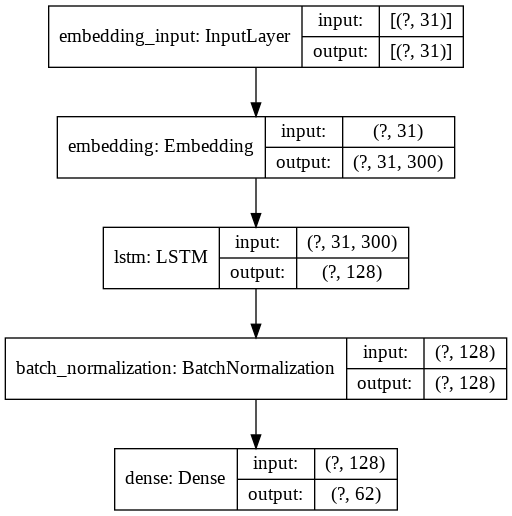

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='vanila_lstm.png', show_shapes=True, show_layer_names=True)

In [2]:
model.compile(optimizer=Adam(learning_rate=0.01), loss=[focal_loss(alpha=0.25, gamma=2)],  metrics=[metrics.Recall(),metrics.Precision(), metrics.AUC()])
model.fit(padded_docs_train, y_train,verbose=1,
                    class_weight='balanced',
                    epochs=2,
                    batch_size=64,
                    validation_split=0.2)


NameError: ignored

In [ ]:
# learning_rate = [0.1,0.01,0.001,0.0001]
# init_mode = ['uniform', 'normal', 'zero']
# units = [128, 50, 256, 512]
# best_score = dict(batch_size=64, Learning_rate=0.01,init_mode='normal',uints = 128)
f_param = [(2.0,0.75),(2.0,1.0)]
res =[]

for f in f_param:
    g,a = f
    print("build model")
    model = Sequential(name='Vanila LSTM')
    # Configuring the parameters
    model.add(Embedding(vocab_size+1, embedding_dim, input_length=max_len, weights=[embeddings_matrix], trainable=False))
    model.add(LSTM(128, return_sequences=False,bias_initializer='normal'))  
    # Adding a dropout layer
    #model.add(Dropout(0.2))
    model.add(BatchNormalization())
    # Adding a dense output layer with sigmoid activation
    model.add(Dense(n_classes, activation='sigmoid',bias_initializer='normal'))
    print("complie......")
    model.compile(optimizer=Adam(learning_rate=0.01), loss=focal_loss(alpha=a, gamma=g),  metrics=[metrics.Recall(),metrics.Precision(), metrics.AUC()])
    #model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=[metrics.AUC(num_thresholds=100)])
    #print("fit with bias units = {}".format(unit))
    model.fit(padded_docs_train, y_train,verbose=1,
                    class_weight='balanced',
                    epochs=2,
                    batch_size=64,
                    validation_split=0.2)
    print("evaluation of the model")
    score = model.evaluate(padded_docs_test,y_test, batch_size=64)
    print(f"score = {score}")
    res.append(score)
    #print("saving the model")
    #model.save(PATH + 'model_batch_64_lr_0.01_unit_{}_loss_{:.4f}_auc_{:.4f}.h5'.format(unit,loss,auc))

build model
complie......
Train on 589416 samples, validate on 147355 samples
Epoch 1/2
589416/589416 [==============================] - 901s 2ms/step - loss: 0.0113 - recall_22: 0.2824 - precision_22: 0.4892 - auc_23: 0.8780 - val_loss: inf - val_recall_22: 0.3015 - val_precision_22: 0.5295 - val_auc_23: 0.8901
Epoch 2/2
589416/589416 [==============================] - 894s 2ms/step - loss: nan - recall_22: 0.2954 - precision_22: 0.5101 - auc_23: 0.7315 - val_loss: nan - val_recall_22: 0.0000e+00 - val_precision_22: 0.0000e+00 - val_auc_23: 0.0000e+00
evaluation of the model
184156/184156 [==============================] - 115s 626us/step
score = [nan, 0.0, 0.0, 0.0]
build model
complie......
Train on 589416 samples, validate on 147355 samples
Epoch 1/2
589416/589416 [==============================] - 868s 1ms/step - loss: nan - recall_23: 0.0268 - precision_23: 0.0218 - auc_24: 4.2294e-04 - val_loss: nan - val_recall_23: 0.0000e+00 - val_precision_23: 0.0000e+00 - val_auc_24: 0.0000e

In [ ]:
res[2]

[0.010085111662391712,
 0.20682448148727417,
 0.7312079668045044,
 0.8924382925033569]

In [ ]:
predictions=model.predict([padded_docs_test])



In [ ]:
print(classification_report(y_test,pred,target_names=tags))

C:\Users\Yoni Pick\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

                android       0.83      0.47      0.60      2742
                  apple       0.66      0.50      0.57      1482
                    art       0.51      0.30      0.38      4710
artificial intelligence       0.52      0.45      0.49      4269
               big data       0.51      0.22      0.31      1142
       blacklivesmatter       0.44      0.02      0.04       974
             blockchain       0.71      0.63      0.67     14910
                   blog       0.18      0.01      0.01      1185
                  books       0.65      0.31      0.42      2719
               business       0.41      0.01      0.01      5483
                culture       0.44      0.02      0.03      3098
                   data       0.27      0.16      0.20      1239
           data science       0.42      0.31      0.36      2555
                 design       0.63      0.42      0.50      8093
                   dogs 

C:\Users\Yoni Pick\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
np.round(predictions[0], 2)

array([0.06, 0.06, 0.09, 0.1 , 0.04, 0.12, 0.05, 0.11, 0.16, 0.19, 0.22,
       0.07, 0.07, 0.1 , 0.07, 0.15, 0.04, 0.16, 0.07, 0.26, 0.08, 0.1 ,
       0.07, 0.29, 0.13, 0.22, 0.09, 0.04, 0.04, 0.05, 0.07, 0.35, 0.3 ,
       0.37, 0.36, 0.08, 0.13, 0.06, 0.11, 0.12, 0.09, 0.2 , 0.07, 0.13,
       0.21, 0.23, 0.09, 0.42, 0.2 , 0.39, 0.19, 0.06, 0.12, 0.09, 0.09,
       0.11, 0.06, 0.06, 0.23, 0.02, 0.12, 0.21], dtype=float32)

In [ ]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [ ]:
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
    acc = accuracy_score(y_test, pred)
    print(f"trashhold value {val}")
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}, accuracy: {:.4f}".format(precision, recall, f1, acc))
    print(f"hamming_score: {hamming_score(np.asarray(y_test),pred)}")

trashhold value 0.1
Micro-average quality numbers
Precision: 0.0445, Recall: 0.9134, F1-measure: 0.0848, accuracy: 0.0000
hamming_score: 0.05673009401483541
trashhold value 0.2
Micro-average quality numbers
Precision: 0.1885, Recall: 0.5435, F1-measure: 0.2799, accuracy: 0.0522
hamming_score: 0.22884435380729284
trashhold value 0.3
Micro-average quality numbers
Precision: 0.5066, Recall: 0.3249, F1-measure: 0.3959, accuracy: 0.2106
hamming_score: 0.30012653609413953
trashhold value 0.4
Micro-average quality numbers
Precision: 0.7198, Recall: 0.2203, F1-measure: 0.3373, accuracy: 0.2000
hamming_score: 0.24145407516815462
trashhold value 0.5
Micro-average quality numbers
Precision: 0.8276, Recall: 0.1472, F1-measure: 0.2499, accuracy: 0.1454
hamming_score: 0.16868660266295965
trashhold value 0.6
Micro-average quality numbers
Precision: 0.8885, Recall: 0.0810, F1-measure: 0.1485, accuracy: 0.0842
hamming_score: 0.09531122164541658
trashhold value 0.7
Micro-average quality numbers
Precisio

In [ ]:
from sklearn.metrics import classification_report
pred=predictions.copy()

val =0.3

pred[pred>=val]=1
pred[pred<val]=0
print(classification_report(y_test,pred,target_names=tags))

                         precision    recall  f1-score   support

                android       0.82      0.50      0.62      2742
                  apple       0.62      0.52      0.57      1482
                    art       0.50      0.30      0.37      4710
artificial intelligence       0.51      0.51      0.51      4269
               big data       0.69      0.24      0.36      1142
       blacklivesmatter       0.26      0.19      0.22       974
             blockchain       0.68      0.72      0.70     14910
                   blog       0.25      0.09      0.13      1185
                  books       0.54      0.42      0.48      2719
               business       0.36      0.12      0.18      5483
                culture       0.46      0.03      0.06      3098
                   data       0.25      0.26      0.25      1239
           data science       0.47      0.27      0.34      2555
                 design       0.59      0.43      0.50      8093
                   dogs 

In [ ]:
from sklearn.metrics import roc_curve,auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

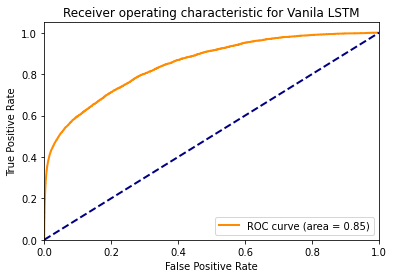

In [ ]:
import matplotlib.pyplot as plt 
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Vanila LSTM')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
n_classes = len(tags)

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        predictions[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], predictions[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    predictions.ravel())
average_precision["micro"] = average_precision_score(y_test, predictions,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.46


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.46')

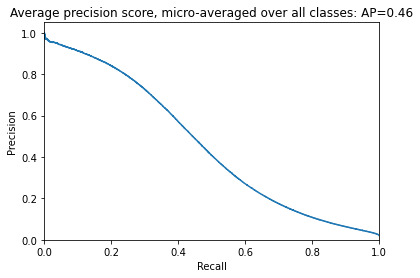

In [ ]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

C:\Users\Yoni Pick\Miniconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


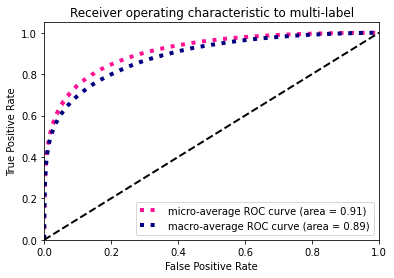

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))
lw=2
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-label')
plt.legend(loc="lower right")
plt.show()


### tune paramters of Vanila LSTM

* tune batch size and training epochs.
* tune optimization algorithms.
* tune learning rate and momentum.
* tune network weight initialization.
* tune activation functions.
* tune dropout regularization.
* tune the number of neurons in the hidden layer.

In [ ]:
def vanila_lstm(lr=0.001,init_mode='uniform', optimizer='adam'):
    # Create modal
    model = Sequential(name='Vanila LSTM')
    model.add(Embedding(vocab_size+1, embedding_dim, input_length=max_len, trainable=True,embeddings_initializer=init_mode))
    model.add(LSTM(512, return_sequences=False, activation='sigmoid',kernel_initializer=init_mode))  
    model.add(BatchNormalization())
    model.add(Dense(n_classes, activation='sigmoid',kernel_initializer=init_mode))
    # Compile model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[metrics.AUC()])

    return model


In [ ]:
#model = KerasClassifier(build_fn=vanila_lstm, verbose=3)
optimizer = ['SGD', 'RMSprop', 'Adam']
for opt in optimizer:
    # create model
    model =vanila_lstm(opt)
    model.fit(padded_docs_train, y_train,verbose=1,
                    class_weight='balanced',
                    epochs=5,
                    batch_size=64,
                    validation_split=0.2)
    loss, auc = model.evaluate(padded_docs_test,y_test, batch_size=64)
    model.save(PATH + 'model_batch_64_lr_{}_loss_{:.4f}_auc_{:.4f}.h5'.format(lr,loss,auc))

C:\Users\Yoni Pick\Miniconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 589416 samples, validate on 147355 samples
Epoch 1/5
  3904/589416 [..............................] - ETA: 3:47:20 - loss: 0.4393 - auc_13: 0.5006

KeyboardInterrupt: 

In [ ]:
# define the grid search parameters
batch_size = [32,64, 256, 512,1024]
epochs = [5]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring='roc_auc', n_jobs=-1, cv=2,verbose=3)
grid_result = grid.fit(padded_docs_train, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 2689.5min remaining: 1152.7min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 3263.2min finished
C:\Users\Yoni Pick\Miniconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
optimizer = ['SGD', 'RMSprop', 'Adam']
param_grid = dict(optimizer=optimizer)
# create model
model = KerasClassifier(build_fn=vanila_lstm, epochs=5, batch_size=512, verbose=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
736771/736771 [==============================] - 98s 133us/step - loss: 0.0851 - accuracy: 5.4729e-07
Epoch 2/5
736771/736771 [==============================] - 95s 129us/step - loss: 0.0577 - accuracy: 7.0053e-07
Epoch 3/5
736771/736771 [==============================] - 95s 128us/step - loss: 0.0513 - accuracy: 1.4886e-06
Epoch 4/5
736771/736771 [==============================] - 96s 130us/step - loss: 0.0463 - accuracy: 2.7364e-06
Epoch 5/5
736771/736771 [==============================] - 95s 128us/step - loss: 0.0431 - accuracy: 3.6997e-06
Best: 0.000857 using {'optimizer': 'Adam'}
0.000000 (0.000000) with: {'optimizer': 'SGD'}
0.000309 (0.000295) with: {'optimizer': 'RMSprop'}
0.000857 (0.001146) with: {'optimizer': 'Adam'}


In [ ]:
# create model
model = KerasClassifier(build_fn=vanila_lstm, epochs=5, batch_size=512, verbose=1)
lr = list([0.0001,0.001, 0.01, 0.1])
param_grid = dict(lr=lr)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
736771/736771 [==============================] - 94s 127us/step - loss: 0.2093 - accuracy: 1.9702e-07
Epoch 2/5
736771/736771 [==============================] - 93s 126us/step - loss: 0.0693 - accuracy: 1.0946e-06
Epoch 3/5
736771/736771 [==============================] - 93s 126us/step - loss: 0.0633 - accuracy: 2.5175e-06
Epoch 4/5
736771/736771 [==============================] - 93s 126us/step - loss: 0.0600 - accuracy: 4.2032e-06
Epoch 5/5
736771/736771 [==============================] - 93s 126us/step - loss: 0.0574 - accuracy: 5.3853e-06
Best: 0.000041 using {'lr': 0.0001}
0.000041 (0.000058) with: {'lr': 0.0001}
0.000014 (0.000007) with: {'lr': 0.001}
0.000000 (0.000000) with: {'lr': 0.01}
nan (nan) with: {'lr': 0.1}


In [ ]:
# create model
model = KerasClassifier(build_fn=vanila_lstm, epochs=5, batch_size=512, verbose=1)
init_mode = ['uniform', 'normal', 'zero']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
736771/736771 [==============================] - 94s 128us/step - loss: 0.2153 - accuracy: 0.0000e+00
Epoch 2/5
736771/736771 [==============================] - 94s 127us/step - loss: 0.0763 - accuracy: 0.0000e+00
Epoch 3/5
736771/736771 [==============================] - 93s 126us/step - loss: 0.0694 - accuracy: 0.0000e+00
Epoch 4/5
736771/736771 [==============================] - 93s 126us/step - loss: 0.0656 - accuracy: 0.0000e+00
Epoch 5/5
736771/736771 [==============================] - 93s 126us/step - loss: 0.0629 - accuracy: 0.0000e+00
Best: 0.000000 using {'init_mode': 'uniform'}
0.000000 (0.000000) with: {'init_mode': 'uniform'}
nan (nan) with: {'init_mode': 'normal'}
nan (nan) with: {'init_mode': 'zero'}


## 2 BiLSTM and attention

> Indented block



In [ ]:
def attention_layer(inputs, neurons):
    X = Permute((2,1))(inputs)
    X = Dense(neurons,activation="sigmoid")(X)
    X = Permute((2,1),name = 'attention')(X)
    X = multiply([inputs,X])
    return X
    

In [ ]:

X_in = Input((max_len,))

X = Embedding(vocab_size+1, 300, input_length=max_len, trainable=False)(X_in)

X = attention_layer(X,neurons=max_len)

X = Bidirectional(LSTM(15, return_sequences=True, bias_initializer='normal', dropout=0.2))(X)
X = Bidirectional(LSTM(15, return_sequences=False, bias_initializer='normal', dropout=0.2))(X)

X = Dense(128,activation='tanh')(X)
y_out = Dense(units=62, activation='sigmoid')(X)

In [ ]:
model = Model(X_in, y_out, name='2 BiLSTM and attention' )
model.compile(loss=[focal_loss(alpha=0.25, gamma=2)], optimizer='adam', metrics=[metrics.Recall(),metrics.Precision(), metrics.AUC()])

In [ ]:

model.summary()

Model: "2 BiLSTM and attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 31, 300)      52481100    input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 300, 31)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 300, 31)      992         permute[0][0]                    
_____________________________________________________________________________

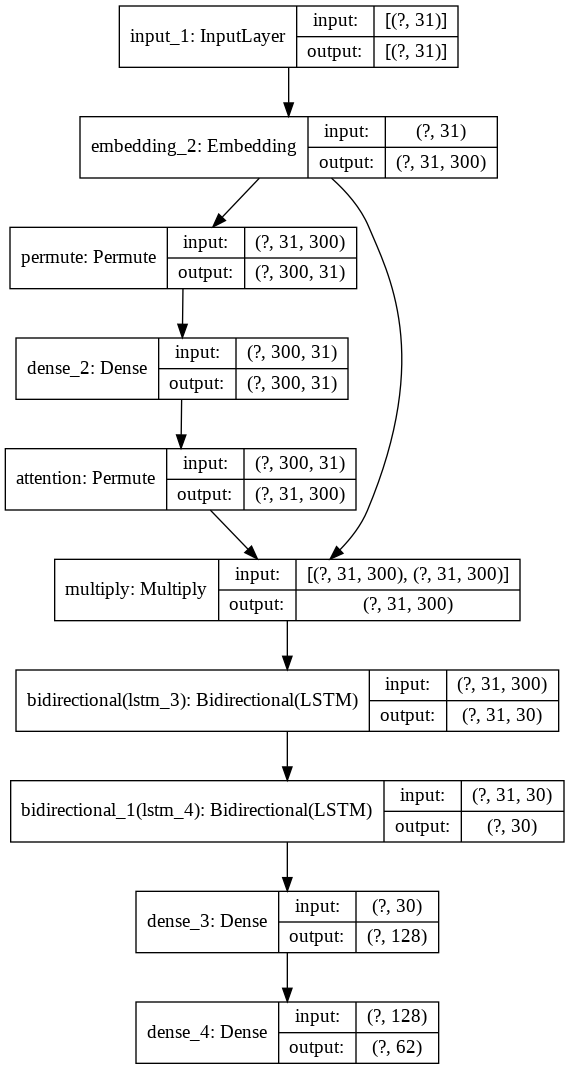

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='2 BiLSTM and attention.png', show_shapes=True, show_layer_names=True)

In [ ]:
  model.fit(padded_docs_train, y_train, verbose=1,
                    class_weight='balanced',
                    epochs=2,
                    batch_size=64,
                    validation_split=0.2)

Train on 589416 samples, validate on 147355 samples
Epoch 1/2
589416/589416 [==============================] - 823s 1ms/step - loss: 0.0080 - recall_29: 0.0304 - precision_29: 0.5775 - auc_30: 0.8425 - val_loss: 0.0071 - val_recall_29: 0.0827 - val_precision_29: 0.8492 - val_auc_30: 0.8830
Epoch 2/2
589416/589416 [==============================] - 822s 1ms/step - loss: 0.0072 - recall_29: 0.0724 - precision_29: 0.8531 - auc_30: 0.8770 - val_loss: 0.0069 - val_recall_29: 0.1013 - val_precision_29: 0.8617 - val_auc_30: 0.8897


In [ ]:
predictions=model.predict([padded_docs_test])
print(classification_report(y_test,pred, target_names=tags))

                         precision    recall  f1-score   support

                android       0.82      0.50      0.62      2742
                  apple       0.62      0.52      0.57      1482
                    art       0.50      0.30      0.37      4710
artificial intelligence       0.51      0.51      0.51      4269
               big data       0.69      0.24      0.36      1142
       blacklivesmatter       0.26      0.19      0.22       974
             blockchain       0.68      0.72      0.70     14910
                   blog       0.25      0.09      0.13      1185
                  books       0.54      0.42      0.48      2719
               business       0.36      0.12      0.18      5483
                culture       0.46      0.03      0.06      3098
                   data       0.25      0.26      0.25      1239
           data science       0.47      0.27      0.34      2555
                 design       0.59      0.43      0.50      8093
                   dogs 

C:\Users\Yoni Pick\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for val in thresholds:
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
    acc = accuracy_score(y_test, pred)
    print(f"trashhold value {val}")
    print("Micro-average quality numbers")
    #print("accuracy: {:.4f}".format(acc))
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}, accuracy: {:.4f}".format(precision, recall, f1, acc))

trashhold value 0.1
Micro-average quality numbers
Precision: 0.0445, Recall: 0.9134, F1-measure: 0.0848, accuracy: 0.0000
trashhold value 0.2
Micro-average quality numbers
Precision: 0.1885, Recall: 0.5435, F1-measure: 0.2799, accuracy: 0.0522
trashhold value 0.3
Micro-average quality numbers
Precision: 0.5066, Recall: 0.3249, F1-measure: 0.3959, accuracy: 0.2106
trashhold value 0.4
Micro-average quality numbers
Precision: 0.7198, Recall: 0.2203, F1-measure: 0.3373, accuracy: 0.2000
trashhold value 0.5
Micro-average quality numbers
Precision: 0.8276, Recall: 0.1472, F1-measure: 0.2499, accuracy: 0.1454
trashhold value 0.6
Micro-average quality numbers
Precision: 0.8885, Recall: 0.0810, F1-measure: 0.1485, accuracy: 0.0842
trashhold value 0.7
Micro-average quality numbers
Precision: 0.9173, Recall: 0.0277, F1-measure: 0.0537, accuracy: 0.0298
trashhold value 0.8
Micro-average quality numbers
Precision: 0.9412, Recall: 0.0043, F1-measure: 0.0085, accuracy: 0.0047
trashhold value 0.9
Micr

In [ ]:
val =0.3
pred=predictions.copy()
pred[pred>=val]=1
pred[pred<val]=0
print(classification_report(y_test,pred, target_names=tags))



                         precision    recall  f1-score   support

                android       0.82      0.50      0.62      2742
                  apple       0.62      0.52      0.57      1482
                    art       0.50      0.30      0.37      4710
artificial intelligence       0.51      0.51      0.51      4269
               big data       0.69      0.24      0.36      1142
       blacklivesmatter       0.26      0.19      0.22       974
             blockchain       0.68      0.72      0.70     14910
                   blog       0.25      0.09      0.13      1185
                  books       0.54      0.42      0.48      2719
               business       0.36      0.12      0.18      5483
                culture       0.46      0.03      0.06      3098
                   data       0.25      0.26      0.25      1239
           data science       0.47      0.27      0.34      2555
                 design       0.59      0.43      0.50      8093
                   dogs 

## 2 LSTM + CONV

In [ ]:
#def create_modal_Lstm_conv():
model = Sequential(name = '2LSTM+CONV')
# Configuring the parameters
model.add(Embedding(vocab_size+1, 300, input_length=max_len, trainable=False))
model.add(LSTM(128, return_sequences=True, bias_initializer='normal'))  
# Adding a dropout layer
model.add(BatchNormalization())
model.add(LSTM(64, return_sequences=True, bias_initializer='normal'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, padding='valid', activation='sigmoid', strides=1))
model.add(GlobalMaxPool1D())
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid', bias_initializer='normal'))

model.compile(optimizer=Adam(learning_rate=0.01), loss=[focal_loss(alpha=.25, gamma=2)], metrics=[metrics.Recall(),metrics.Precision(), metrics.AUC()])
  

#return model

In [ ]:
   model.summary()

Model: "2LSTM+CONV"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 300)           52481100  
_________________________________________________________________
lstm_1 (LSTM)                (None, 31, 128)           219648    
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 128)           512       
_________________________________________________________________
lstm_2 (LSTM)                (None, 31, 64)            49408     
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 64)            256       
_________________________________________________________________
conv1d (Conv1D)              (None, 29, 64)            12352     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0

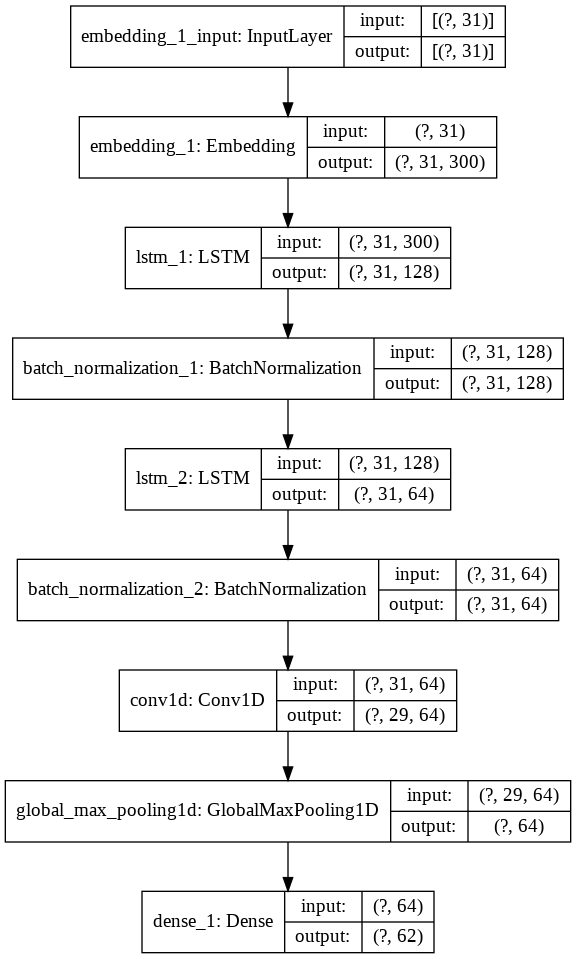

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='2LSTM+CONV.png', show_shapes=True, show_layer_names=True)

In [ ]:
  model.fit(padded_docs_train, y_train,verbose=1,
                    class_weight='balanced',
                    epochs=2,
                    batch_size=64,
                    validation_split=0.2)

Train on 589416 samples, validate on 147355 samples
Epoch 1/2
589416/589416 [==============================] - 1373s 2ms/step - loss: 0.0074 - recall_30: 0.0805 - precision_30: 0.7840 - auc_31: 0.8627 - val_loss: 0.0071 - val_recall_30: 0.1070 - val_precision_30: 0.8328 - val_auc_31: 0.8768
Epoch 2/2
589416/589416 [==============================] - 1372s 2ms/step - loss: 0.0071 - recall_30: 0.1013 - precision_30: 0.8259 - auc_31: 0.8757 - val_loss: 0.0071 - val_recall_30: 0.1159 - val_precision_30: 0.8087 - val_auc_31: 0.8777


In [ ]:
predictions=model.predict([padded_docs_test])
print(classification_report(y_test,pred, target_names=tags))

                         precision    recall  f1-score   support

                android       0.82      0.50      0.62      2742
                  apple       0.62      0.52      0.57      1482
                    art       0.50      0.30      0.37      4710
artificial intelligence       0.51      0.51      0.51      4269
               big data       0.69      0.24      0.36      1142
       blacklivesmatter       0.26      0.19      0.22       974
             blockchain       0.68      0.72      0.70     14910
                   blog       0.25      0.09      0.13      1185
                  books       0.54      0.42      0.48      2719
               business       0.36      0.12      0.18      5483
                culture       0.46      0.03      0.06      3098
                   data       0.25      0.26      0.25      1239
           data science       0.47      0.27      0.34      2555
                 design       0.59      0.43      0.50      8093
                   dogs 

C:\Users\Yoni Pick\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for val in thresholds:
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
    acc = accuracy_score(y_test, pred)
    print(f"trashhold value {val}")
    print("Micro-average quality numbers")
    #print("accuracy: {:.4f}".format(acc))
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}, accuracy: {:.4f}".format(precision, recall, f1, acc))

trashhold value 0.1
Micro-average quality numbers
Precision: 0.0484, Recall: 0.9000, F1-measure: 0.0919, accuracy: 0.0001
trashhold value 0.2
Micro-average quality numbers
Precision: 0.2194, Recall: 0.5196, F1-measure: 0.3086, accuracy: 0.0801
trashhold value 0.3
Micro-average quality numbers
Precision: 0.4861, Recall: 0.3230, F1-measure: 0.3881, accuracy: 0.2187
trashhold value 0.4
Micro-average quality numbers
Precision: 0.6811, Recall: 0.2068, F1-measure: 0.3173, accuracy: 0.1859
trashhold value 0.5
Micro-average quality numbers
Precision: 0.8033, Recall: 0.1153, F1-measure: 0.2017, accuracy: 0.1131
trashhold value 0.6
Micro-average quality numbers
Precision: 0.8945, Recall: 0.0273, F1-measure: 0.0529, accuracy: 0.0259
trashhold value 0.7
Micro-average quality numbers
Precision: 0.9474, Recall: 0.0080, F1-measure: 0.0160, accuracy: 0.0070
trashhold value 0.8
Micro-average quality numbers
Precision: 0.7500, Recall: 0.0000, F1-measure: 0.0000, accuracy: 0.0000


C:\Users\Yoni Pick\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


trashhold value 0.9
Micro-average quality numbers
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000, accuracy: 0.0000


In [ ]:
val =0.3
pred=predictions.copy()
pred[pred>=val]=1
pred[pred<val]=0
print(classification_report(y_test,pred, target_names=tags))



                         precision    recall  f1-score   support

                android       0.80      0.46      0.58      2742
                  apple       0.60      0.51      0.55      1482
                    art       0.51      0.32      0.39      4710
artificial intelligence       0.49      0.47      0.48      4269
               big data       0.32      0.37      0.34      1142
       blacklivesmatter       0.00      0.00      0.00       974
             blockchain       0.67      0.62      0.65     14910
                   blog       0.24      0.02      0.03      1185
                  books       0.38      0.48      0.42      2719
               business       0.24      0.16      0.19      5483
                culture       0.40      0.06      0.10      3098
                   data       0.23      0.29      0.25      1239
           data science       0.46      0.26      0.34      2555
                 design       0.64      0.40      0.49      8093
                   dogs 

In [ ]:
hamming_loss(y_test,pred)

0.017844618412580077

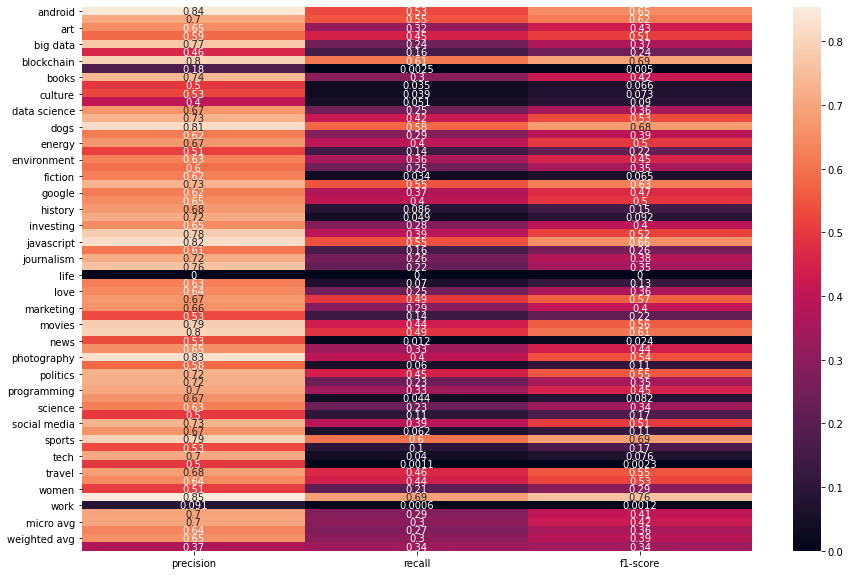

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 10))
sns.heatmap(pd.DataFrame(cls_report).iloc[:-1, :].T,annot=True);

In [ ]:
i = 4
print(np.argmax(predictions[i]))
print(np.argmax(y_test[i]))

56
56


In [ ]:
test.head()

,Title,android,apple,art,artificial intelligence,big data,blacklivesmatter,blockchain,blog,books,business,culture,data,data science,design,dogs,education,energy,entrepreneurship,environment,feminism,fiction,food,google,health,history,humor,investing,ios,javascript,jobs,journalism,leadership,life,life lessons,love,machine learning,marketing,mobile,movies,music,news,parenting,photography,poetry,politics,productivity,programming,psychology,science,self improvement,social media,software engineering,sports,startup,tech,technology,travel,web development,women,wordpress,work,writing,word_cnt,language,key_word,tags,number_unique_words,number_unique_key_word,number_letters,number_unique_letters,number_stopwords
0,a great psychologists test which door are you ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,12,en,great psychologists test afraid to enter great...,None,12,6,51,19,5
1,judith bernsteins money shot,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,en,judith bernsteins money bernsteins money shot ...,None,4,4,25,15,0
2,the fil aus trilogy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,en,fil aus trilogy aus trilogy fil aus,None,4,3,16,14,1
3,how do electric motors work,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6,en,electric motors work motors work electric motors,work,6,3,23,14,2
4,top things to do in san francisco day,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,9,en,san francisco day top things francisco day,None,9,5,30,15,3


In [ ]:
# save model 
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(PATH + "model_2LSTM_1COV.h5")
print("Saved model to disk")

Saved model to disk


## Pooled RNN


In [ ]:
def antirectifier(x):
    x -= K.mean(x, axis=1, keepdims=True)
    x = K.l2_normalize(x, axis=1)
    pos = K.relu(x)
    neg = K.relu(-x)
    return K.concatenate([pos, neg], axis=1)


In [ ]:
#def model_pooled_RNN(learning_rate = 0.001):
  #n_classes = len(tags)
inputs = Input(shape=(max_len,))
# Configuring the parameters
emb = Embedding(vocab_size+1, 300, input_length=max_len, trainable=False)(inputs)
X = SpatialDropout1D(0.1)(emb)
X = Bidirectional(LSTM(128, return_sequences=True))(X)
X = Bidirectional(LSTM(128, return_sequences=True))(X)
  #L = Lambda(antirectifier)(X)
GMP = GlobalMaxPool1D()(X)
GAP = GlobalAveragePooling1D()(X)
C = Concatenate()([GMP,GAP])
D = Dropout(0.2)(C)
X = Dense(128,activation='relu')(D)
outputs = Dense(n_classes,activation='sigmoid')(X)  

model = Model(inputs=inputs, outputs=outputs , name='Pooled RNN')

model.compile(optimizer=Adam(learning_rate=0.01), loss=[focal_loss(alpha=.25, gamma=2)], metrics=[metrics.Recall(),metrics.Precision(), metrics.AUC()])

#  return model

In [ ]:
model.summary()

Model: "Pooled RNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 31, 300)      52481100    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 31, 300)      0           embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 31, 256)      439296      spatial_dropout1d[0][0]          
_________________________________________________________________________________________

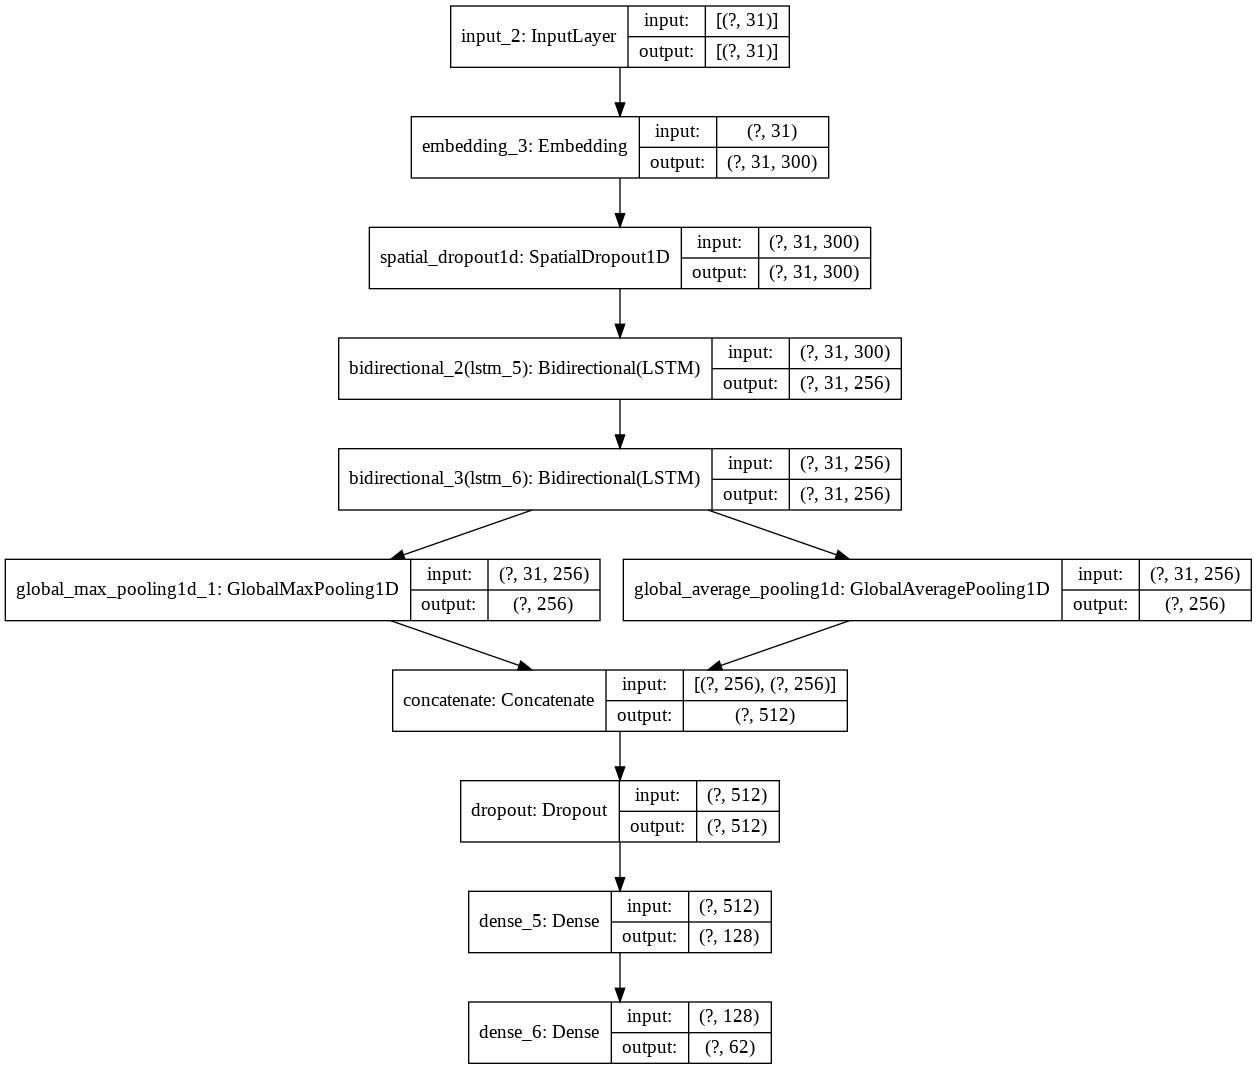

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='Pooled RNN.png', show_shapes=True, show_layer_names=True)

In [ ]:
  model.fit(padded_docs_train, y_train,verbose=1,
                    class_weight='balanced',
                    epochs=2,
                    batch_size=64,
                    validation_split=0.2)

Train on 589416 samples, validate on 147355 samples
Epoch 1/2
589416/589416 [==============================] - 3484s 6ms/step - loss: 0.0072 - recall_32: 0.0915 - precision_32: 0.8131 - auc_33: 0.8732 - val_loss: 0.0067 - val_recall_32: 0.1186 - val_precision_32: 0.8533 - val_auc_33: 0.8954
Epoch 2/2
589416/589416 [==============================] - 3394s 6ms/step - loss: 0.0068 - recall_32: 0.1126 - precision_32: 0.8461 - auc_33: 0.8901 - val_loss: 0.0067 - val_recall_32: 0.1114 - val_precision_32: 0.8662 - val_auc_33: 0.8972


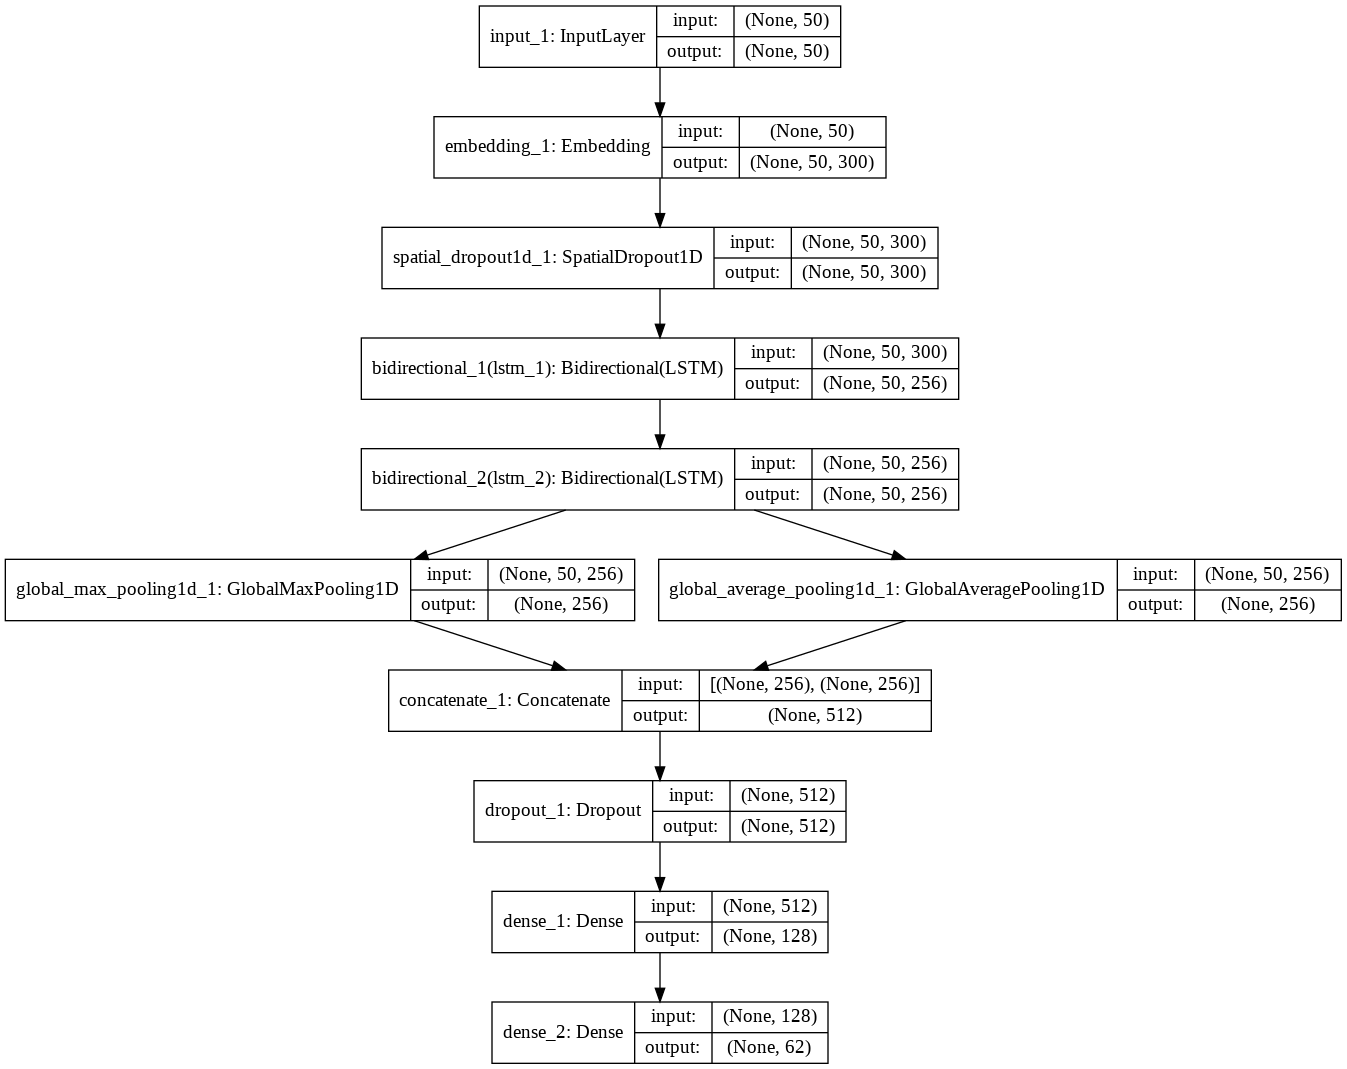

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy',  metrics=[metrics.Precision(),metrics.Recall()])
model = KerasClassifier(build_fn=model_pooled_RNN, epochs=5,batch_size=128,verbose=1)
# define the grid search parameters
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

grid_result = grid.fit(padded_docs_train, y_train)

Epoch 1/5
 48384/491180 [=>............................] - ETA: 3:12:08 - loss: 0.1132 - precision_4: 0.0249 - recall_4: 0.0075

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
predictions=model.predict([padded_docs_test])
print(classification_report(y_test,predictions, target_names=tags))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [ ]:
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for val in thresholds:
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
    print(f"trashhold value {val}")
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

trashhold value 0.1
Micro-average quality numbers
Precision: 0.0487, Recall: 0.9238, F1-measure: 0.0925
trashhold value 0.2
Micro-average quality numbers
Precision: 0.2098, Recall: 0.5963, F1-measure: 0.3104
trashhold value 0.3
Micro-average quality numbers
Precision: 0.5210, Recall: 0.3631, F1-measure: 0.4279
trashhold value 0.4
Micro-average quality numbers
Precision: 0.7483, Recall: 0.2136, F1-measure: 0.3323
trashhold value 0.5
Micro-average quality numbers
Precision: 0.8651, Recall: 0.1111, F1-measure: 0.1969
trashhold value 0.6
Micro-average quality numbers
Precision: 0.9207, Recall: 0.0495, F1-measure: 0.0940
trashhold value 0.7
Micro-average quality numbers
Precision: 0.9518, Recall: 0.0187, F1-measure: 0.0368
trashhold value 0.8
Micro-average quality numbers
Precision: 0.9663, Recall: 0.0043, F1-measure: 0.0086
trashhold value 0.9
Micro-average quality numbers
Precision: 0.9831, Recall: 0.0002, F1-measure: 0.0005


In [ ]:
val =0.3
pred=predictions.copy()
pred[pred>=val]=1
pred[pred<val]=0
print(classification_report(y_test,pred, target_names=tags))

                         precision    recall  f1-score   support

                android       0.69      0.55      0.61      2742
                  apple       0.75      0.47      0.58      1482
                    art       0.59      0.29      0.39      4710
artificial intelligence       0.53      0.47      0.50      4269
               big data       0.48      0.34      0.40      1142
       blacklivesmatter       0.32      0.14      0.20       974
             blockchain       0.67      0.72      0.70     14910
                   blog       0.15      0.00      0.00      1185
                  books       0.57      0.42      0.48      2719
               business       0.29      0.14      0.19      5483
                culture       0.43      0.03      0.06      3098
                   data       0.27      0.14      0.19      1239
           data science       0.35      0.43      0.39      2555
                 design       0.72      0.40      0.52      8093
                   dogs 

In [ ]:
clf_report = classification_report(y_test,pred, target_names=tags,output_dict=True)

C:\Users\Yoni Pick\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


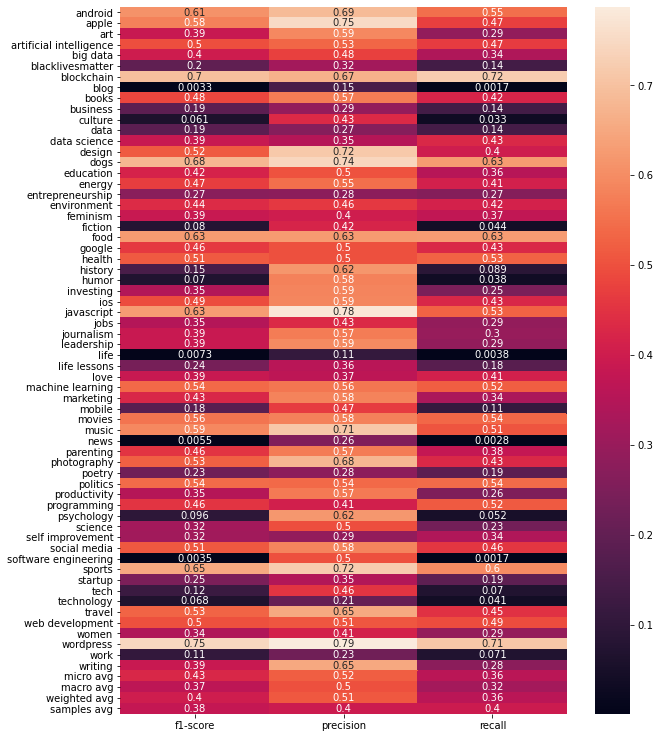

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,13))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True);


## maxpool Text CNN

In [ ]:
inputs = Input(shape=(max_len,))
# Configuring the parameters
emb = Embedding(vocab_size+1, embedding_dim, input_length=max_len, weights=[embeddings_matrix], trainable=False)(inputs)
X = SpatialDropout1D(0.1)(emb)

conv1 = Conv1D(50, 3, padding='valid', activation='relu', strides=1)(X)
conv2 = Conv1D(50, 3, padding='valid', activation='relu', strides=1)(X)
conv3 = Conv1D(50, 3, padding='valid', activation='relu', strides=1)(X)
conv4 = Conv1D(50, 3, padding='valid', activation='relu', strides=1)(X)

maxpool1 = GlobalMaxPool1D()(conv1)
maxpool2 = GlobalMaxPool1D()(conv2)
maxpool3 = GlobalMaxPool1D()(conv3)
maxpool4 = GlobalMaxPool1D()(conv4)

C = Concatenate()([maxpool1,maxpool2,maxpool3,maxpool4])
D = Dropout(0.2)(C)
X = Dense(64,activation='relu')(D)
outputs = Dense(n_classes,activation='sigmoid')(X)  

model = Model(inputs=inputs, outputs=outputs, name='maxpool text CNN')

In [ ]:
model.summary()

Model: "maxpool text CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 31, 300)      52481100    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 31, 300)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 29, 50)       45050       spatial_dropout1d_1[0][0]        
___________________________________________________________________________________

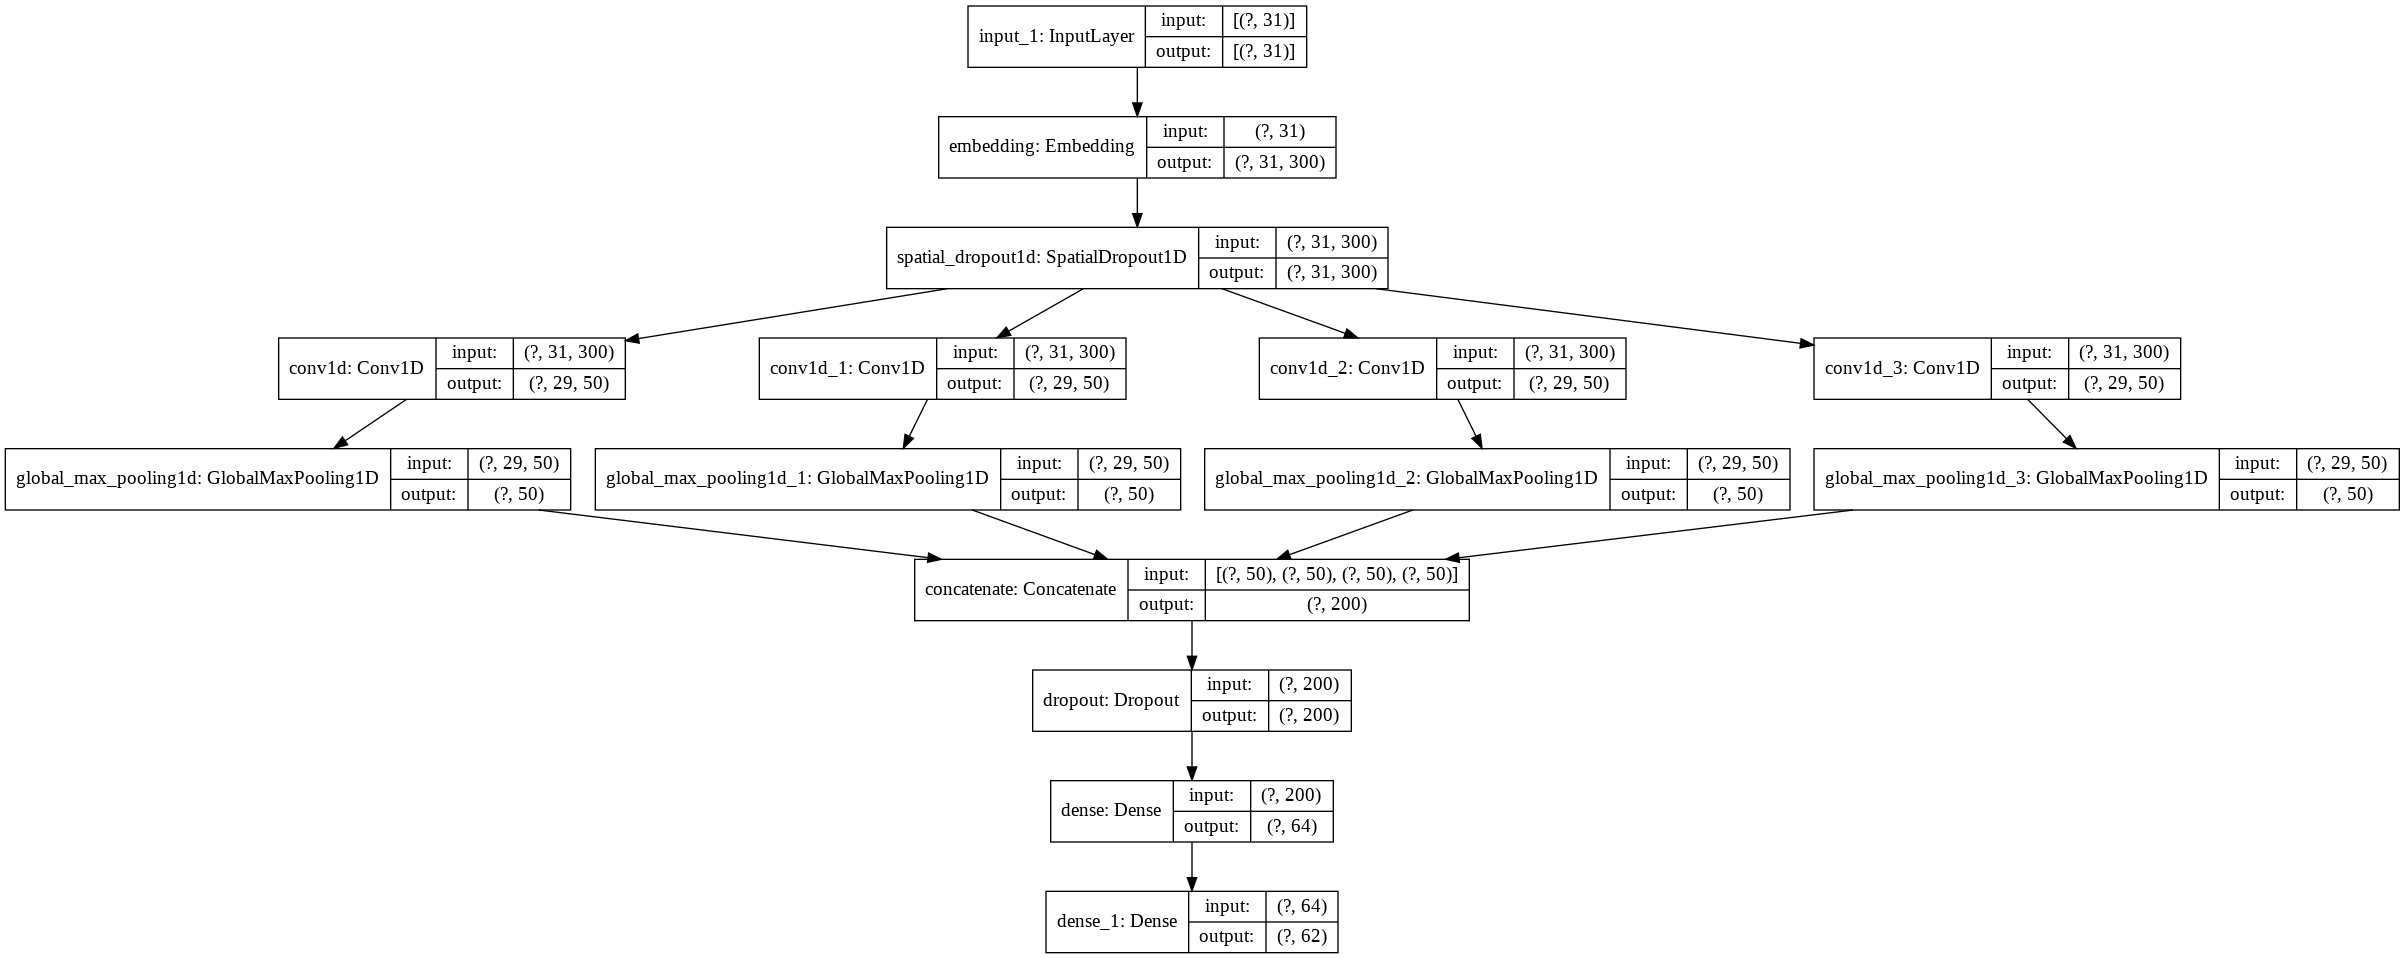

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='maxpool text CNN.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=[focal_loss(alpha=.25, gamma=2)], metrics=[metrics.Recall(),metrics.Precision(), metrics.AUC()])
history = model.fit(padded_docs_train, y_train,
                    class_weight='balanced',
                    epochs=30,
                    batch_size=64,
                    validation_split=0.2
                    )

AttributeError: ignored

In [ ]:
predictions=model.predict([padded_docs_test])


In [ ]:
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
    acc = accuracy_score(y_test, pred)
    print(f"trashhold value {val}")
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}, acc: {:.4f}".format(precision, recall, f1, acc))

trashhold value 0.1
Micro-average quality numbers
Precision: 0.0576, Recall: 0.9160, F1-measure: 0.1084, acc: 0.0029
trashhold value 0.2
Micro-average quality numbers
Precision: 0.2324, Recall: 0.6361, F1-measure: 0.3404, acc: 0.0979
trashhold value 0.3
Micro-average quality numbers
Precision: 0.5248, Recall: 0.4287, F1-measure: 0.4719, acc: 0.2830
trashhold value 0.4
Micro-average quality numbers
Precision: 0.7286, Recall: 0.2988, F1-measure: 0.4238, acc: 0.2765
trashhold value 0.5
Micro-average quality numbers
Precision: 0.8454, Recall: 0.1947, F1-measure: 0.3165, acc: 0.1968
trashhold value 0.6
Micro-average quality numbers
Precision: 0.9178, Recall: 0.0927, F1-measure: 0.1684, acc: 0.0991
trashhold value 0.7
Micro-average quality numbers
Precision: 0.9532, Recall: 0.0290, F1-measure: 0.0562, acc: 0.0331
trashhold value 0.8
Micro-average quality numbers
Precision: 0.9713, Recall: 0.0040, F1-measure: 0.0079, acc: 0.0049
trashhold value 0.9
Micro-average quality numbers
Precision: 1.0

In [ ]:
pred=predictions.copy()
val=0.3
pred[pred>=val]=1
pred[pred<val]=0
print(classification_report(y_test,pred, target_names=tags))

                         precision    recall  f1-score   support

                android       0.70      0.67      0.68      2742
                  apple       0.62      0.63      0.62      1482
                    art       0.55      0.33      0.41      4710
artificial intelligence       0.52      0.57      0.55      4269
               big data       0.38      0.49      0.43      1142
       blacklivesmatter       0.37      0.28      0.31       974
             blockchain       0.75      0.83      0.79     14910
                   blog       0.26      0.08      0.12      1185
                  books       0.56      0.46      0.51      2719
               business       0.39      0.12      0.18      5483
                culture       0.40      0.08      0.13      3098
                   data       0.26      0.36      0.30      1239
           data science       0.48      0.39      0.43      2555
                 design       0.54      0.56      0.55      8093
                   dogs 

In [ ]:
test.iloc[0,0]

'a great psychologists test which door are you afraid to enter '

In [ ]:
pred[0].argmax()

47

In [ ]:
y_test[0].argmax()

49